The purpose here is to check the forward waveform simulation is working properly. In particular, does varying each parameter generate results consistent with physics intuition?

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc

from pathlib import Path

import time as Ti
from scipy import optimize

import synthetic as syn
import calcol as calcol
import helpers as hp
import ButterWorth as bw
import pred as pd
import objective as ob
import load_data
import load_all_gfs

import os

dir_path = os.path.dirname(os.path.realpath('scale_waveforms'))
path = Path(dir_path)
parent_path = str(path.parent.absolute())
vel_disp_flag = 'VEL'
GPS_flag = 'YES' 
comp_flag = 'NO'
coord_flag = 'CYLINDRICAL'

# load Green's functions
dt = 0.05
T = np.arange(-20, 60, dt)    # resampled time for dynamic model output
T[np.argmin(abs(T))] = 0      # make sure 0 s exists
mt_gf_file = 'greens_functions/halfspace_Kilauea/half_1.94_mt/'
sf_gf_file = 'greens_functions/halfspace_Kilauea/half_1.94_sf/'

load_all_gfs.init(mt_gf_file, sf_gf_file, T)

# piston and chamber locations
parameters = np.loadtxt(dir_path+'/inversion_input/parameters.txt', delimiter=',', usecols= 1)
chamber_cent = np.array(parameters[:3])
chamber_cent[2] = -1940 # z positive upwards
piston_cent = np.array(parameters[:3])

# Trim data to focus on the period of interest 
if vel_disp_flag == 'VEL':
    lb_time = 0
    ub_time = 60
elif vel_disp_flag == 'DIS':
    lb_time = 0
    ub_time = 30

# load data
load_data.init(lb_time, ub_time, vel_disp_flag, GPS_flag)
data = load_data.data
#data_cov = load_data.data_cov

# Load accelerometer locations (w/ origin NPIT)
accel_pos_xy = np.loadtxt(dir_path+'/inversion_input/acce_local_xy.txt', delimiter=',', skiprows=1) 
accel_labels = ['HMLE', 'NPT', 'PAUD', 'RSDD', 'UWE']

# Load broadband seismometer locations (w/ origin NPIT)
seism_pos_xy = np.loadtxt(dir_path+'/inversion_input/seism_local_xy.txt', delimiter=',', skiprows=1) 
seism_labels = ['HLPD', 'JOKA', 'MLOD', 'STCD']

# Load GPS station locations, if required (w/ origin NPIT)
if GPS_flag == 'YES':
    # exclude UWE, NPT seismic stations, UWEV GPS station
    sta_pos = np.zeros((19, 3))

    GPS_pos_xy = np.loadtxt(dir_path+'/inversion_input/gps_local_xy.txt', delimiter=',', skiprows=1) 
    GPS_labels = ['69FL', '92YN', 'AHUP', 'BDPK', 'BYRL', 'CNPK', 'CRIM', 'DEVL', 'OUTL', 'PUHI', 'PWRL', 'UWEV', 'V120', 'VSAS']
    
    sta_pos[:3, :2] = accel_pos_xy[[0, 2, 3], :]
    sta_pos[3:6, :2] = seism_pos_xy[[0, 1, 2],:]
    sta_pos[6:17, :2] = GPS_pos_xy[:11, :]
    sta_pos[[17,18], :2] = GPS_pos_xy[[12,13], :]

elif GPS_flag == 'YES':
    # exclude UWE, NPT
    sta_pos = np.zeros((3, 3)) 
    sta_pos[:3, :2] = accel_pos_xy[[0, 2, 3], :]
    sta_pos[3:6, :2] = seism_pos_xy[[0, 1, 2],:]
    
    
# Input for objective function to evaluate posterior probability----------------------------------------------------
# default input-----------------------------------------------------------------------------------------------
md_vec = [10**(-9.52), 5.21e+09, 1.95e+05,  1.01e+02, 1.1, 2.31e+03, 5.03e+02, 3.43, 3.33, 4.52, 1.48, 1.14, 6.99e-01, 3.12, 1.62, 3.19, -9.39e-01, -7e-01, -5e-01] # Default values
bnds = np.array([[-9.7, -8.88], [2, 7.23], [0.1, 1.3], [0.21, 0.87], [1, 1.4], [2.4, 2.8], [0.5, 1.3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3], [-3, 3]]) 
g = 9.8   # gravitational constant [m/s^2]
mu = 3e9  #
param_vec = [g, sta_pos, chamber_cent, piston_cent, lb_time, ub_time, vel_disp_flag, comp_flag, coord_flag, GPS_flag, T, mu]

cmap = mpl.cm.hot

inverted parameters:
1. compressibility 2. chamber volume 3. shear strength drop 4. effective magma density 5. aspect ratio 6. rock density 7. piston radius 

### Total compressibility

As compressiblity increases, so does the characteristic time scale of the problem, making the duration of collapse longer.

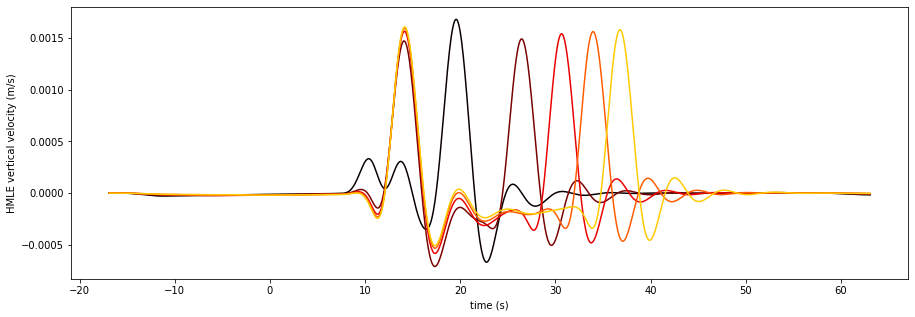

In [3]:
beta_list = np.linspace(10**(-9.7), 10**(-8.5), 5)
md_vec_default = md_vec[:]

fig = plt.figure(figsize=(15,5))
for i, beta in enumerate(beta_list):
    md_vec_default[0] = beta
    pred = pd.pred(md_vec_default, param_vec)
    sta_pred_time = pred[0][0][1] # get HMLE
    sta_pred_z = pred[1][1]  # vertical component 
    plt.plot(sta_pred_time, sta_pred_z, color=cmap(i / len(beta_list)/1.2))
plt.xlabel("time (s)")
plt.ylabel("HMLE vertical velocity (m/s)")
plt.savefig('sensitivity_beta.eps', format='eps')


### Chamber volume

The larger the chamber volume, the larger $t^*$, which increases the duration of velocity waveform.

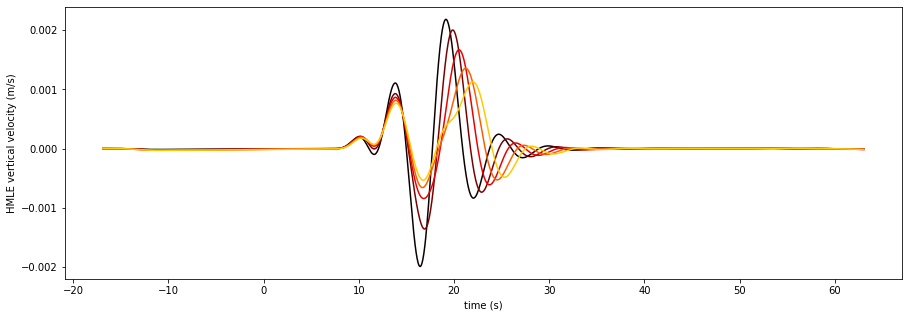

In [4]:
V_list = np.linspace(2*10**9, 7.23*10**9, 5)
md_vec_default = md_vec[:]

fig = plt.figure(figsize=(15,5))
for i, V in enumerate(V_list):
    md_vec_default[1] = V
    pred = pd.pred(md_vec_default, param_vec)
    sta_pred_time = pred[0][0][1] # get HMLE
    sta_pred_z = pred[1][1]  # vertical component 
    plt.plot(sta_pred_time, sta_pred_z, color=cmap(i / len(V_list)/1.2))
plt.xlabel("time (s)")
plt.ylabel("HMLE vertical velocity (m/s)")
plt.savefig('sensitivity_V.eps', format='eps')


### Static-dynamic stress drop

The piston is initially at static equilibrium. The larger the stress drop, the larger the amplitude of single force, which makes the surface velocity amplitudes increase.

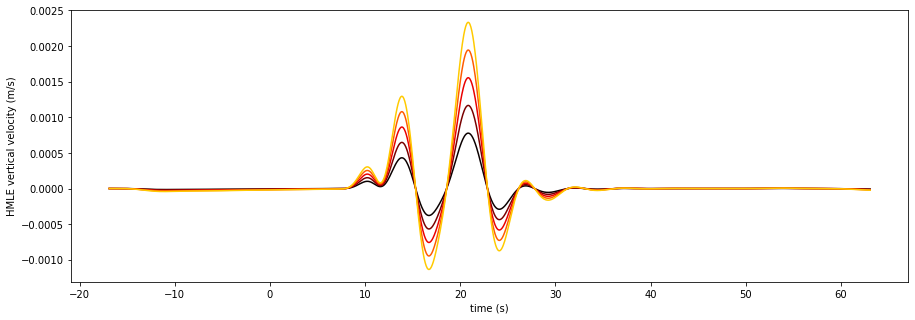

In [5]:
dtau_list = np.linspace(0.1e6, 0.3e6, 5)
md_vec_default = md_vec[:]

fig = plt.figure(figsize=(15,5))
for i, dtau in enumerate(dtau_list):
    md_vec_default[2] = dtau
    pred = pd.pred(md_vec_default, param_vec)
    sta_pred_time = pred[0][0][1] # get HMLE
    sta_pred_z = pred[1][1]  # vertical component 
    plt.plot(sta_pred_time, sta_pred_z, color=cmap(i / len(dtau_list)/1.2))
plt.xlabel("time (s)")
plt.ylabel("HMLE vertical velocity (m/s)")
plt.savefig('sensitivity_dtau.eps', format='eps')


### rock density

Increase rock density increases the dimensionless number $\pi_0$, which represents the force deficit on the piston after the initial stress drop. Increase $\pi_0$ increases $t_{max}$, making the duration of collapse longer.

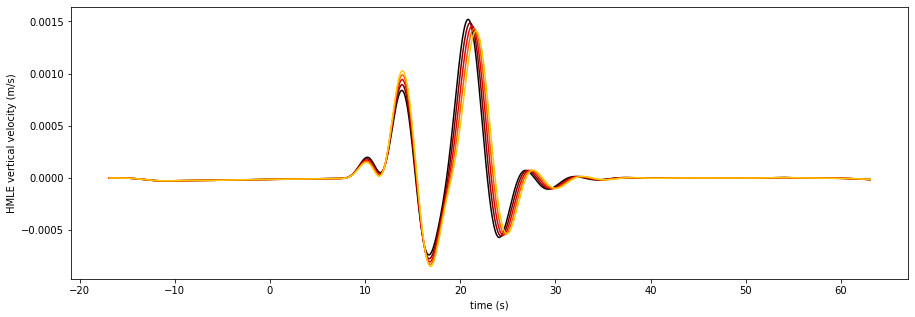

In [5]:
rho_list = np.linspace(2300, 3000, 5)
md_vec_default = md_vec[:]

fig = plt.figure(figsize=(15,5))
for i, rho in enumerate(rho_list):
    md_vec_default[5] = rho
    pred = pd.pred(md_vec_default, param_vec)
    sta_pred_time = pred[0][0][1] # get HMLE
    sta_pred_z = pred[1][1]  # vertical component 
    plt.plot(sta_pred_time, sta_pred_z, color=cmap(i / len(rho_list)/1.2))
plt.xlabel("time (s)")
plt.ylabel("HMLE vertical velocity (m/s)")
plt.savefig('sensitivity_rho.eps', format='eps')

### effective magma density

The higher the effective magma density, the longer the charateristic time and length scale, and the smaller the $\pi_0$. This makes the velocity waveform have longer duration, and smaller amplitudes.

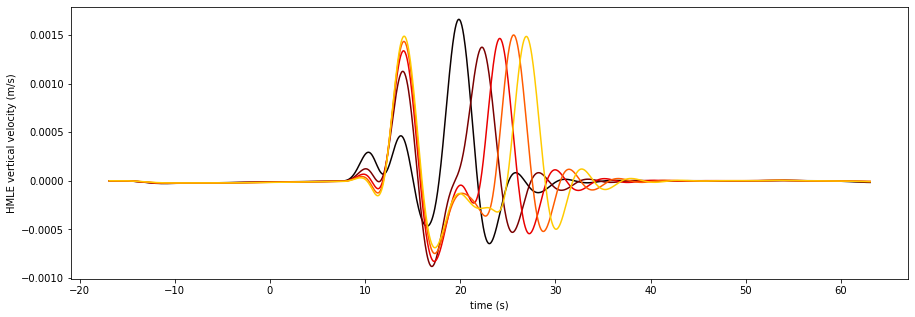

In [6]:
eff_rho_list = np.linspace(0, 1000, 5)
md_vec_default = md_vec[:]

fig = plt.figure(figsize=(15,5))
for i, eff_rho in enumerate(eff_rho_list):
    md_vec_default[3] = eff_rho
    pred = pd.pred(md_vec_default, param_vec)
    sta_pred_time = pred[0][0][1] # get HMLE
    sta_pred_z = pred[1][1]  # vertical component 
    plt.plot(sta_pred_time, sta_pred_z, color=cmap(i / len(eff_rho_list)/1.2))
plt.xlabel("time (s)")
plt.ylabel("HMLE vertical velocity (m/s)")
plt.savefig('sensitivity_eff_rho.eps', format='eps')

### piston radius

Increase piston radius, R, decreases $t^*$ and $l^*$, which make the collapse faster. Maximum pressure perturbation should increase, making the overall amplitude of velocity larger.

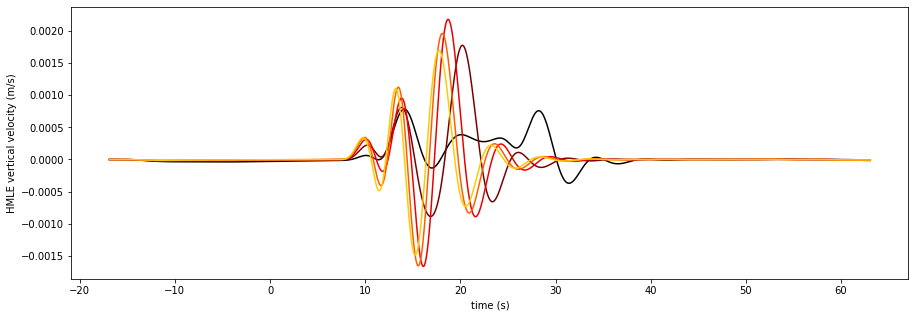

In [7]:
R_list = np.linspace(300, 1300, 5)
md_vec_default = md_vec[:]

fig = plt.figure(figsize=(15,5))
for i, R in enumerate(R_list):
    md_vec_default[6] = R
    pred = pd.pred(md_vec_default, param_vec)
    sta_pred_time = pred[0][0][1] # get HMLE
    sta_pred_z = pred[1][1]  # vertical component 
    plt.plot(sta_pred_time, sta_pred_z, color=cmap(i / len(R_list)/1.2))
plt.xlabel("time (s)")
plt.ylabel("HMLE vertical velocity (m/s)")
plt.savefig('sensitivity_R.eps', format='eps')

### chamber aspect ratio

Increase chamber aspect ratio reduces vertical surface displacement/velocity

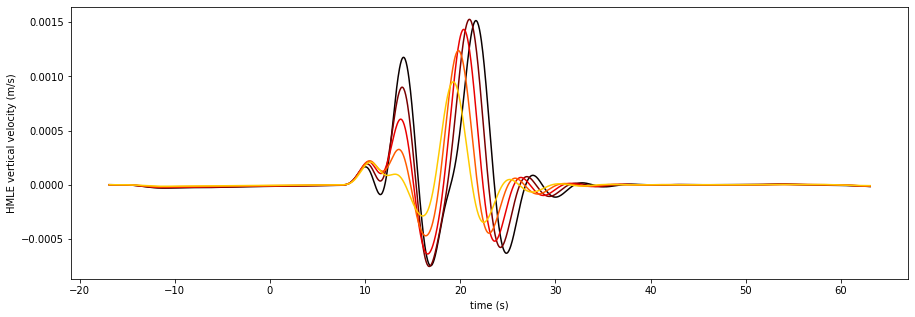

In [8]:
alpha_list = np.linspace(0.8, 1.8, 5)
md_vec_default = md_vec[:]

fig = plt.figure(figsize=(15,5))
for i, alpha in enumerate(alpha_list):
    md_vec_default[4] = alpha
    pred = pd.pred(md_vec_default, param_vec)
    sta_pred_time = pred[0][0][1] # get HMLE
    sta_pred_z = pred[1][1]  # vertical component 
    plt.plot(sta_pred_time, sta_pred_z, color=cmap(i / len(alpha_list)/1.2))
plt.xlabel("time (s)")
plt.ylabel("HMLE vertical velocity (m/s)")
plt.savefig('sensitivity_alpha.eps', format='eps')
    